In [2]:
%load_ext autoreload
%autoreload 2

In [2]:
# Install transformer and peft if you don't have it installed
# ! pip install transformers==4.31.0
# ! pip install peft
# ! pip install accelerate
# ! pip install bitsandbytes

# ! pip install jsonlines
# ! pip install sqlglot

This is a standalone notebook to train the NSQL model on a single GPU (e.g., A5000 with 24GB) with int8 and LoRA.

# Load the model

In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
# tokenizer = AutoTokenizer.from_pretrained("NumbersStation/nsql-llama-2-7B")
# model = AutoModelForCausalLM.from_pretrained("NumbersStation/nsql-llama-2-7B", load_in_8bit=True, torch_dtype=torch.bfloat16, device_map='auto')

# import torch
# from transformers import AutoTokenizer, AutoModelForCausalLM
# tokenizer = AutoTokenizer.from_pretrained("NumbersStation/nsql-350M")
# model = AutoModelForCausalLM.from_pretrained("NumbersStation/nsql-350M")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
tokenizer = AutoTokenizer.from_pretrained("/notebooks/llm-workspace/nsql-llama-2-7B/")
model = AutoModelForCausalLM.from_pretrained("/notebooks/llm-workspace/nsql-llama-2-7B/", load_in_8bit=True, torch_dtype=torch.bfloat16, device_map='auto')


Loading checkpoint shards: 100%|██████████| 3/3 [00:19<00:00,  6.38s/it]
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


In [5]:
# model.save_pretrained('/notebooks/llm-workspace/nsql-llama-2-7B_quan')

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [7]:
from datasets import load_dataset
df1=load_dataset('csv',data_files='AudioCalls_FineTuning_Dataset.csv',split='train')

Generating train split: 4 examples [00:00, 723.22 examples/s]


In [8]:
df1

Dataset({
    features: ['instruction', 'output', 'source'],
    num_rows: 4
})

In [136]:
torch.cuda.empty_cache()

# Prepare the data

We use NumbersStation/NSText2SQL dataset as an example here and feel free to customize the training data based on your need.

In [159]:
from datasets import load_dataset
from torch.utils.data import Dataset
import copy

class NSText2SQLDataset(Dataset):
    def __init__(self, size=None, max_seq_length=2048):
        # df1=load_dataset('csv',data_files='AudioCalls_FineTuning_Dataset.csv')
        self.dataset = load_dataset('csv',data_files='AudioCalls_FineTuning_Dataset.csv',split='train')
        if size:
            self.dataset = self.dataset.select(range(size))
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        instruction = torch.tensor(tokenizer.encode(self.dataset[index]['instruction']), dtype=torch.int64)
        example = self.dataset[index]['instruction'] + self.dataset[index]["output"]
        example = tokenizer.encode(example)
        example.append(tokenizer.eos_token_id)
        padding = self.max_seq_length - len(example)
        example = torch.tensor(example, dtype=torch.int64)

        if padding < 0:
            example = example[:self.max_seq_length]
        else:
            example = torch.cat((example, torch.zeros(padding, dtype=torch.int64)))
            
        labels = copy.deepcopy(example)
        labels[: len(instruction)] = -100
        
        return {"input_ids": example, "labels": labels}

In [160]:
dataset = NSText2SQLDataset(size=4, max_seq_length=1024)

In [161]:
dataset.dataset


Dataset({
    features: ['instruction', 'output', 'source'],
    num_rows: 4
})

# Prepare PEFT for model training

In [162]:
from peft import (
    get_peft_model,
    LoraConfig,
    TaskType,
    prepare_model_for_int8_training,
    
)
# lora_dropout=0.05,

# model.train()

model = prepare_model_for_int8_training(model)

lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=['q_proj', 'v_proj', 'k_proj']
   
    
)
 #["q_proj", "v_proj"] 

model = get_peft_model(model, lora_config)

/usr/local/lib/python3.10/dist-packages/peft/utils/other.py:141: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(


# Finetune the model with Huggingface trainer

In [163]:
from transformers import default_data_collator, Trainer, TrainingArguments

output_dir = "training_run"

config = {
    'lora_config': lora_config,
    'learning_rate': 3e-4,
    'num_train_epochs': 3,
    'gradient_accumulation_steps': 4,
    'gradient_checkpointing': False,
    
}
# learning_rate=5e-4,

training_args = TrainingArguments(
    output_dir=output_dir,
    overwrite_output_dir=True,
    bf16=True,
    # logging strategies
    logging_dir=f"{output_dir}/logs",
    logging_strategy="steps",
    logging_steps=5,
    optim="adamw_torch_fused",
     remove_unused_columns=False,
    **{k:v for k,v in config.items() if k != 'lora_config'}
)

In [164]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=default_data_collator,
)

# Start training
trainer.train()

Detected kernel version 5.4.181, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Epoch,Training Loss,Validation Loss
1,No log,16.263018
2,No log,14.713525
3,No log,14.002871


TrainOutput(global_step=3, training_loss=4.168399492899577, metrics={'train_runtime': 26.3521, 'train_samples_per_second': 0.455, 'train_steps_per_second': 0.114, 'total_flos': 488073943056384.0, 'train_loss': 4.168399492899577, 'epoch': 3.0})

In [167]:
peft_model_path="/notebooks/llm-workspace/peft-nsql_llama2_7B-checkpoint/"

# Save model checkpoint

In [166]:
trainer.model.save_pretrained(peft_model_path)
tokenizer.save_pretrained(peft_model_path)
# model.save_pretrained(output_dir)

('/notebooks/llm-workspace/peft-nsql_llama2_7B-checkpoint/tokenizer_config.json',
 '/notebooks/llm-workspace/peft-nsql_llama2_7B-checkpoint/special_tokens_map.json',
 '/notebooks/llm-workspace/peft-nsql_llama2_7B-checkpoint/tokenizer.json')

# Merge Base with peft layers

In [9]:
from peft import PeftModel, PeftConfig
peft_model_path="/notebooks/llm-workspace/peft-nsql_llama2_7B-checkpoint/"

# peft_model_base = AutoModelForSeq2SeqLM.from_pretrained("google/flan-t5-base", torch_dtype=torch.bfloat16)
# tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-base")

tokenizer = AutoTokenizer.from_pretrained("/notebooks/llm-workspace/nsql-llama-2-7B/")
peft_model_base = AutoModelForCausalLM.from_pretrained("/notebooks/llm-workspace/nsql-llama-2-7B/", load_in_8bit=True, torch_dtype=torch.bfloat16, device_map='auto')


peft_model = PeftModel.from_pretrained(peft_model_base, 
                                       peft_model_path, 
                                       torch_dtype=torch.bfloat16,
                                       is_trainable=False)


Loading checkpoint shards: 100%|██████████| 3/3 [00:19<00:00,  6.52s/it]
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`. This was detected when initializing the generation config instance, which means the corresponding file may hold incorrect parameterization and should be fixed.
  warnings.warn(


In [10]:
text = """CREATE TABLE STREAMLITAPPTABLE (
            DATETIME DATE,
            AUDIO_FILE_NAME VARCHAR(100),
            DURATION FLOAT,
            CALLTOACTION VARCHAR(16777216),
            CLAIMNUMBER VARCHAR(16777216),
            CUSTOMER VARCHAR(16777216),
            INTENT VARCHAR(16777216),
            ISSUE VARCHAR(16777216),
            POLICYNUMBER VARCHAR(16777216),
            PURPOSEOFCALL VARCHAR(16777216),
            REPRESENTATIVE VARCHAR(16777216),
            RESOLUTION VARCHAR(16777216),
            RESPONSEMODE VARCHAR(16777216),
            MODEOFUPDATE VARCHAR(16777216),
            NEXTSTEPS VARCHAR(16777216),
            CALLSENTIMENT VARCHAR(8),
            FIRSTCALLRESOLUTION VARCHAR(3)
        )

-- Using valid SQLite, answer the following questions for the tables provided above.

-- What is the total call durations for all agents for last month?

SELECT"""

model_input = tokenizer(text, return_tensors="pt").to("cuda")

generated_ids = peft_model.generate(**model_input, max_new_tokens=100)
res=tokenizer.decode(generated_ids[0][len(model_input[0])-1:], skip_special_tokens=True)


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:394: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.bfloat16 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


In [11]:
print(res)

SELECT SUM(DURATION) FROM STREAMLITAPPTABLE WHERE DATETIME > DATEADD(month, -1, GETDATE())


In [ ]:
#  -- Using valid SQLite, answer the following questions for the tables provided above. -- sum of call duration week on week  ?
text = """CREATE TABLE STREAMLITAPPTABLE (
            DATETIME DATE,
            AUDIO_FILE_NAME VARCHAR(100),
            DURATION FLOAT,
            CALLTOACTION VARCHAR(16777216),
            CLAIMNUMBER VARCHAR(16777216),
            CUSTOMER VARCHAR(16777216),
            INTENT VARCHAR(16777216),
            ISSUE VARCHAR(16777216),
            POLICYNUMBER VARCHAR(16777216),
            PURPOSEOFCALL VARCHAR(16777216),
            REPRESENTATIVE VARCHAR(16777216),
            RESOLUTION VARCHAR(16777216),
            RESPONSEMODE VARCHAR(16777216),
            MODEOFUPDATE VARCHAR(16777216),
            NEXTSTEPS VARCHAR(16777216),
            CALLSENTIMENT VARCHAR(8),
            FIRSTCALLRESOLUTION VARCHAR(3)  -- Using valid SQLite, answer the following questions for the tables provided above. -- sum of call duration week on week  ?

SELECT"""

model_input = tokenizer(text, return_tensors="pt").to("cuda")

generated_ids = trainer.model.generate(**model_input, max_new_tokens=500)
print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))

In [12]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    return f"trainable model parameters: {trainable_model_params}\nall model parameters: {all_model_params}\npercentage of trainable model parameters: {100 * trainable_model_params / all_model_params:.2f}%"


In [14]:
print(print_number_of_trainable_model_parameters(peft_model))

trainable model parameters: 0
all model parameters: 6750998528
percentage of trainable model parameters: 0.00%


In [ ]:
# tokenizer.save_pretrained()

# Evaluate the finetuned model

In [129]:
model.eval()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PeftModelForCausalLM(
      (base_model): LoraModel(
        (model): PeftModelForCausalLM(
          (base_model): LoraModel(
            (model): PeftModelForCausalLM(
              (base_model): LoraModel(
                (model): PeftModelForCausalLM(
                  (base_model): LoraModel(
                    (model): PeftModelForCausalLM(
                      (base_model): LoraModel(
                        (model): LlamaForCausalLM(
                          (model): LlamaModel(
                            (embed_tokens): Embedding(32000, 4096, padding_idx=2)
                            (layers): ModuleList(
                              (0-31): 32 x LlamaDecoderLayer(
                                (self_attn): LlamaAttention(
                                  (q_proj): lora.Linear8bitLt(
                                    (base_layer): Linear8bitLt(in_features=4096, out_features=4096, bias=False)
             

In [130]:
text = """CREATE TABLE STREAMLITAPPTABLE (
	DATETIME DATE,
	AUDIO_FILE_NAME VARCHAR(100),
	DURATION FLOAT,
	CALLTOACTION VARCHAR(16777216),
	CLAIMNUMBER VARCHAR(16777216),
	CUSTOMER VARCHAR(16777216),
	INTENT VARCHAR(16777216),
	ISSUE VARCHAR(16777216),
	POLICYNUMBER VARCHAR(16777216),
	PURPOSEOFCALL VARCHAR(16777216),
	REPRESENTATIVE VARCHAR(16777216),
	RESOLUTION VARCHAR(16777216),
	RESPONSEMODE VARCHAR(16777216),
	RESPONSETIME VARCHAR(16777216),
)

-- Using valid SQLite, answer the following questions for the tables provided above.

-- What is the total call durations for all agents for last month?

SELECT"""

model_input = tokenizer(text, return_tensors="pt").to("cuda")

generated_ids = model.generate(**model_input, max_new_tokens=100)
print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))

CREATE TABLE STREAMLITAPPTABLE (
	DATETIME DATE,
	AUDIO_FILE_NAME VARCHAR(100),
	DURATION FLOAT,
	CALLTOACTION VARCHAR(16777216),
	CLAIMNUMBER VARCHAR(16777216),
	CUSTOMER VARCHAR(16777216),
	INTENT VARCHAR(16777216),
	ISSUE VARCHAR(16777216),
	POLICYNUMBER VARCHAR(16777216),
	PURPOSEOFCALL VARCHAR(16777216),
	REPRESENTATIVE VARCHAR(16777216),
	RESOLUTION VARCHAR(16777216),
	RESPONSEMODE VARCHAR(16777216),
	RESPONSETIME VARCHAR(16777216),
)

-- Using valid SQLite, answer the following questions for the tables provided above.

-- What is the total call durations for all agents for last month?

SELECT SUM(DURATION) FROM STREAMLITAPPTABLE WHERE DATETIME > DATEADD(month, -1, GETDATE())


In [21]:
#  -- Using valid SQLite, answer the following questions for the tables provided above. -- sum of call duration week on week  ?
text = '''CREATE TABLE STREAMLITAPPTABLE (
	DATETIME DATE,
	AUDIO_FILE_NAME VARCHAR(100),
	DURATION FLOAT,
	CALLTOACTION VARCHAR(16777216),
	CLAIMNUMBER VARCHAR(16777216),
	CUSTOMER VARCHAR(16777216),
	INTENT VARCHAR(16777216),
	ISSUE VARCHAR(16777216),
	POLICYNUMBER VARCHAR(16777216),
	PURPOSEOFCALL VARCHAR(16777216),
	REPRESENTATIVE VARCHAR(16777216),
	RESOLUTION VARCHAR(16777216),
	RESPONSEMODE VARCHAR(16777216),
	RESPONSETIME VARCHAR(16777216))  -- Using valid SQLite, answer the following questions for the tables provided above. -- sum of call duration week on week  ?

'''

model_input = tokenizer(text, return_tensors="pt").to("cuda")

generated_ids = peft_model.generate(**model_input, max_new_tokens=500)
# print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))
print(tokenizer.decode(generated_ids[0][len(model_input[0])-1:], skip_special_tokens=True).strip().replace('"',"'"))

SELECT SUM(DURATION) FROM STREAMLITAPPTABLE;


In [153]:
# peft_model.save_pretrained("/notebooks/llm-workspace/nsql-llama-2-7B-peftmerged/")

In [84]:
# !pip install snowflake-ml-python

In [76]:
input_str="What is the distinct purpose of the calls in the last month"
text = f"""CREATE TABLE STREAMLITAPPTABLE (
	DATETIME DATE,
	AUDIO_FILE_NAME VARCHAR(100),
	DURATION FLOAT,
	CALLTOACTION VARCHAR(16777216),
	CLAIMNUMBER VARCHAR(16777216),
	CUSTOMER VARCHAR(16777216),
	INTENT VARCHAR(16777216),
	ISSUE VARCHAR(16777216),
	POLICYNUMBER VARCHAR(16777216),
	PURPOSEOFCALL VARCHAR(16777216),
	REPRESENTATIVE VARCHAR(16777216),
	RESOLUTION VARCHAR(16777216),
	RESPONSEMODE VARCHAR(16777216),
	RESPONSETIME VARCHAR(16777216),
)

-- Using valid SQLite, answer the following questions for the tables provided above.

-- {input_str}

SELECT"""

model_input = tokenizer(text, return_tensors="pt").to("cuda")

generated_ids = model.generate(**model_input, max_new_tokens=100)
# print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))
print(tokenizer.decode(generated_ids[0][len(model_input[0])-1:], skip_special_tokens=True).strip().replace('"',"'"))

CREATE TABLE STREAMLITAPPTABLE (
	DATETIME DATE,
	AUDIO_FILE_NAME VARCHAR(100),
	DURATION FLOAT,
	CALLTOACTION VARCHAR(16777216),
	CLAIMNUMBER VARCHAR(16777216),
	CUSTOMER VARCHAR(16777216),
	INTENT VARCHAR(16777216),
	ISSUE VARCHAR(16777216),
	POLICYNUMBER VARCHAR(16777216),
	PURPOSEOFCALL VARCHAR(16777216),
	REPRESENTATIVE VARCHAR(16777216),
	RESOLUTION VARCHAR(16777216),
	RESPONSEMODE VARCHAR(16777216),
	RESPONSETIME VARCHAR(16777216),
)

-- Using valid SQLite, answer the following questions for the tables provided above.

-- What is the distinct purpose of the calls in the last month

SELECT DISTINCT PURPOSEOFCALL FROM STREAMLITAPPTABLE WHERE DATETIME >= DATEADD(month, -1, GETDATE())


In [23]:
text = """CREATE TABLE STREAMLITAPPTABLE (
	DATETIME DATE,
	AUDIO_FILE_NAME VARCHAR(100),
	DURATION FLOAT,
	CALLTOACTION VARCHAR(16777216),
	CLAIMNUMBER VARCHAR(16777216),
	CUSTOMER VARCHAR(16777216),
	INTENT VARCHAR(16777216),
	ISSUE VARCHAR(16777216),
	POLICYNUMBER VARCHAR(16777216),
	PURPOSEOFCALL VARCHAR(16777216),
	REPRESENTATIVE VARCHAR(16777216),
	RESOLUTION VARCHAR(16777216),
	RESPONSEMODE VARCHAR(16777216),
	RESPONSETIME VARCHAR(16777216),
)

-- Using valid SQLite, answer the following questions for the tables provided above.

-- Give me details for the audio file audio1.mp3?

SELECT"""

model_input = tokenizer(text, return_tensors="pt").to("cuda")

generated_ids = model.generate(**model_input, max_new_tokens=500)
print(tokenizer.decode(generated_ids[0][len(model_input[0])-1:], skip_special_tokens=True).strip().replace('"',"'"))

SELECT * FROM STREAMLITAPPTABLE WHERE AUDIO_FILE_NAME = 'audio1.mp3'


In [23]:
text = """
CREATE TABLE STREAMLITAPPTABLE (
	DATETIME DATE,
	AUDIO_FILE_NAME VARCHAR(100),
	DURATION FLOAT,
	CALLTOACTION VARCHAR(16777216),
	CLAIMNUMBER VARCHAR(16777216),
	CUSTOMER VARCHAR(16777216),
	INTENT VARCHAR(16777216),
	ISSUE VARCHAR(16777216),
	POLICYNUMBER VARCHAR(16777216),
	PURPOSEOFCALL VARCHAR(16777216),
	REPRESENTATIVE VARCHAR(16777216),
	RESOLUTION VARCHAR(16777216),
	RESPONSEMODE VARCHAR(16777216),
	RESPONSETIME VARCHAR(16777216),
)

-- Using valid SQLite, answer the following questions for the tables provided above.

-- what is the resolution for the audio file audio1.mp3?

SELECT"""

model_input = tokenizer(text, return_tensors="pt").to("cuda")

generated_ids = model.generate(**model_input, max_new_tokens=100)
print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))


CREATE TABLE STREAMLITAPPTABLE (
	DATETIME DATE,
	AUDIO_FILE_NAME VARCHAR(100),
	DURATION FLOAT,
	CALLTOACTION VARCHAR(16777216),
	CLAIMNUMBER VARCHAR(16777216),
	CUSTOMER VARCHAR(16777216),
	INTENT VARCHAR(16777216),
	ISSUE VARCHAR(16777216),
	POLICYNUMBER VARCHAR(16777216),
	PURPOSEOFCALL VARCHAR(16777216),
	REPRESENTATIVE VARCHAR(16777216),
	RESOLUTION VARCHAR(16777216),
	RESPONSEMODE VARCHAR(16777216),
	RESPONSETIME VARCHAR(16777216),
)

-- Using valid SQLite, answer the following questions for the tables provided above.

-- what is the resolution for the audio file audio1.mp3?

SELECT RESOLUTION FROM STREAMLITAPPTABLE WHERE AUDIO_FILE_NAME = "audio1.mp3";


In [69]:
res=tokenizer.decode(generated_ids[0][len(model_input[0])-1:], skip_special_tokens=True).strip()
res


'SELECT DURATION, COUNT(DURATION) FROM STREAMLITAPPTABLE GROUP BY DURATION;'

In [70]:
text = """
CREATE TABLE STREAMLITAPPTABLE (
	DATETIME DATE,
	AUDIO_FILE_NAME VARCHAR(100),
	DURATION FLOAT,
	CALLTOACTION VARCHAR(16777216),
	CLAIMNUMBER VARCHAR(16777216),
	CUSTOMER VARCHAR(16777216),
	INTENT VARCHAR(16777216),
	ISSUE VARCHAR(16777216),
	POLICYNUMBER VARCHAR(16777216),
	PURPOSEOFCALL VARCHAR(16777216),
	REPRESENTATIVE VARCHAR(16777216),
	RESOLUTION VARCHAR(16777216),
	RESPONSEMODE VARCHAR(16777216),
	RESPONSETIME VARCHAR(16777216),
)

-- Using valid SQLite, answer the following questions for the tables provided above. 

-- Give me the all the call where the response time is shortly. Replace double quotes with single in the query ?

"""

model_input = tokenizer(text, return_tensors="pt").to("cuda")


generated_ids = model.generate(**model_input, max_new_tokens=500) 
print(tokenizer.decode(generated_ids[0][len(model_input[0])-1:], skip_special_tokens=True).strip())



SELECT CALLTOACTION FROM STREAMLITAPPTABLE WHERE RESPONSETIME = "shortly"


In [56]:
tokenizer.decode(generated_ids[0][len(generated_ids[0]):], skip_special_tokens=True)

''

In [ ]:
text = """
CREATE TABLE STREAMLITAPPTABLE (
	DATETIME DATE,
	AUDIO_FILE_NAME VARCHAR(100),
	DURATION FLOAT,
	CALLTOACTION VARCHAR(16777216),
	CLAIMNUMBER VARCHAR(16777216),
	CUSTOMER VARCHAR(16777216),
	INTENT VARCHAR(16777216),
	ISSUE VARCHAR(16777216),
	POLICYNUMBER VARCHAR(16777216),
	PURPOSEOFCALL VARCHAR(16777216),
	REPRESENTATIVE VARCHAR(16777216),
	RESOLUTION VARCHAR(16777216),
	RESPONSEMODE VARCHAR(16777216),
	RESPONSETIME VARCHAR(16777216),
)

-- Using valid SQLite, answer the following questions for the tables provided above.

-- what is the sum of call duration for every representative and for every resolution ?

SELECT"""

model_input = tokenizer(text, return_tensors="pt").to("cuda")

generated_ids = model.generate(**model_input, max_new_tokens=500)
print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))

In [48]:
text = """
CREATE TABLE STREAMLITAPPTABLE (
	DATETIME DATE,
	AUDIO_FILE_NAME VARCHAR(100),
	DURATION FLOAT,
	CALLTOACTION VARCHAR(16777216),
	CLAIMNUMBER VARCHAR(16777216),
	CUSTOMER VARCHAR(16777216),
	INTENT VARCHAR(16777216),
	ISSUE VARCHAR(16777216),
	POLICYNUMBER VARCHAR(16777216),
	PURPOSEOFCALL VARCHAR(16777216),
	REPRESENTATIVE VARCHAR(16777216),
	RESOLUTION VARCHAR(16777216),
	RESPONSEMODE VARCHAR(16777216),
	RESPONSETIME VARCHAR(16777216),
)

-- Using valid SQLite, answer the following questions for the tables provided above. 

-- Give me the all the call where the response time is shortly.

"""

model_input = tokenizer(text, return_tensors="pt").to("cuda")


generated_ids = model.generate(**model_input, max_new_tokens=500) 
print(tokenizer.decode(generated_ids[0][len(model_input[0])-1:], skip_special_tokens=True).strip())

Using valid SQLite, answer the following questions for the tables provided above. 

-- Give me the all the call where the response time is shortly. Replace double quotes with single in the query ?

SELECT CALLTOACTION FROM STREAMLITAPPTABLE WHERE RESPONSETIME = "shortly"


### Expose the Model as an API

- Open a terminal and run the below command or you can execute the below cell directly
```bash
sh ./RunFastAPI.sh
```

In [ ]:
%%sh
chmod +x RunFastAPI.sh
./RunFastAPI.sh

### Wait for the above command until you see the following output
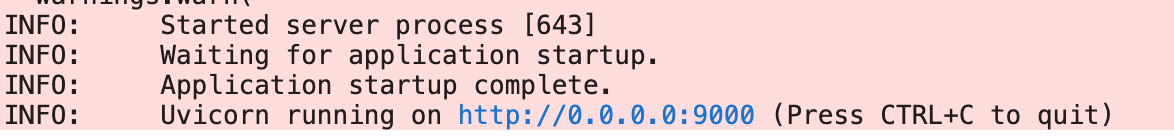

### Go to the readme file for the next steps